# COVID and Pneumonia Dataset

https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia

**Context**

COVID-19 (coronavirus disease 2019) is an infectious disease caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2), a strain of coronavirus. The first cases were seen in Wuhan, China, in late December 2019 before spreading globally. The current outbreak was officially recognized as a pandemic by the World Health Organization (WHO) on 11 March 2020.
Currently Reverse transcription polymerase chain reaction (RT-PCR) is used for diagnosis of the COVID-19. X-ray machines are widely available and provide images for diagnosis quickly so chest X-ray images can be very useful in early diagnosis of COVID-19.

**Content**

Dataset is organized into 2 folders (train, test) and both train and test contain 3 subfolders (COVID19, PNEUMONIA, NORMAL). DataSet contains total 6432 x-ray images and test data have 20% of total images.

Importing Libraries

In [ ]:
#!pip install torch torchvision

import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting Dataset Paths

In [ ]:
# Setting Base Path
base_path = '/content/drive/My Drive/CSE 6242/archive/Data'

# Setting path for both training and testing
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

Visualizing some of the images

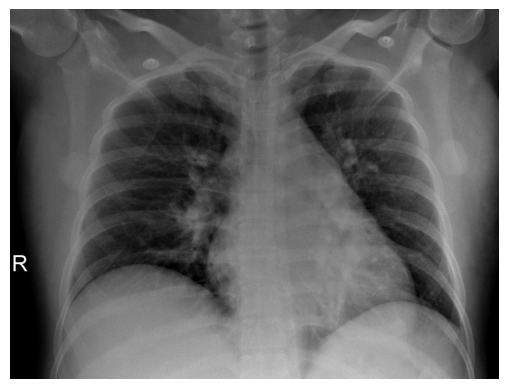

In [ ]:
image_path = train_dir + '/PNEUMONIA/PNEUMONIA(2087).jpg'

img = Image.open(image_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

images are grey scale and have a variety of different sizes we need to deal with

Preprocessing our images - batches and resizing

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Our images are grayscale - xrays but ensuring consistency with this transform
    transforms.Resize((400, 300)), # Resizing our images to a consistent size (some images were huge)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
# Creating our data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Loop through the combined data loader to inspect
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    break

Batch of images shape: torch.Size([32, 1, 400, 300])
Batch of labels: tensor([1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2,
        0, 2, 2, 1, 2, 0, 0, 2])


We have the correct tensor length we are interested in

Setting up model framework

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional layer (input channels = 1 for grayscale xray, output channels = 16)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer (input channels = 16, output channels = 32)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Max pooling layer (2x2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 100 * 75, 128)  # After two 2x2 poolings, the image becomes 100x75
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # Apply first convolution + ReLU + max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolution + ReLU + max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 100 * 75)

        # Fully connected layer + ReLU
        x = F.relu(self.fc1(x))

        # Output layer -CrossEntropyLoss
        x = self.fc2(x)

        return x

Initializing Model's loss function and optimizer

In [ ]:
model = SimpleCNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Defining loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer - Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training our Model

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: compute predictions
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Running Model

In [ ]:
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.3916
Epoch [2/10], Loss: 0.1559
Epoch [3/10], Loss: 0.1038
Epoch [4/10], Loss: 0.0721
Epoch [5/10], Loss: 0.0444
Epoch [6/10], Loss: 0.0250
Epoch [7/10], Loss: 0.0155
Epoch [8/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0087
Epoch [10/10], Loss: 0.0013


Evaluate Model

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate(model, test_loader, criterion, class_names):
    model.eval()

    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():  # Disabled for faster inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    average_loss = total_loss / len(test_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted F1-score
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)  # Balanced accuracy

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Loss: {average_loss:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

    return f1, balanced_acc

Test Loss: 0.2637
F1 Score (Weighted): 0.9493
Balanced Accuracy: 0.9536


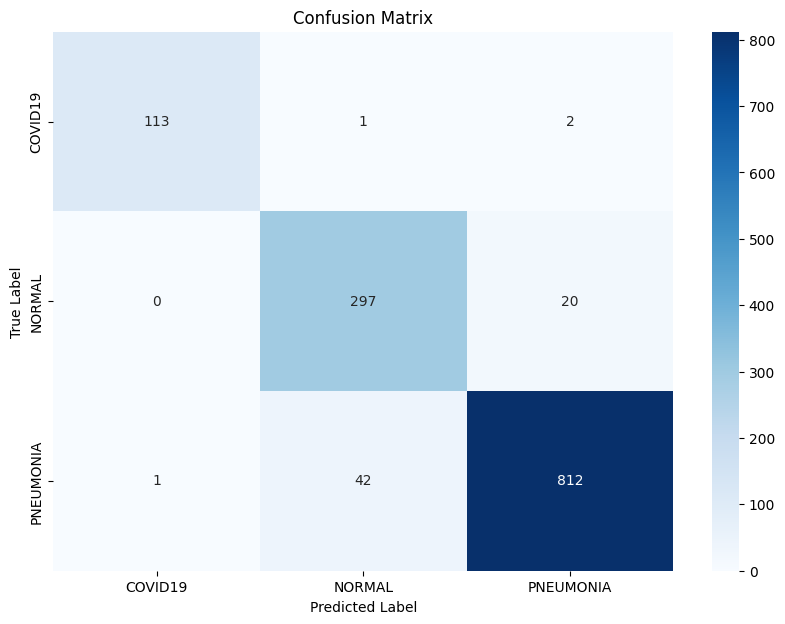

(0.949286695003207, 0.9535846835746072)

In [ ]:
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']

evaluate(model, test_loader, criterion, class_names)

Saving our model

In [ ]:
torch.save(model, 'cnn.pth')

# Running our model - api

In [ ]:
# loading our model
loading_model = torch.load("cnn.pth")
loading_model.eval() # no longer training model

<ipython-input-82-8d4d4de5e87d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loading_model = torch.load("cnn.pth")


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=240000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

Function for running inference on image

In [ ]:
def run_inference_on_image(model, image, classes):

    img = Image.open(image).convert('L')

    # TODO: Create separate function for transformations
    # Using same transformations from our model (making sure we convert it in the same format)
    transform = transforms.Compose([
        transforms.Resize((400, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Applying transformations on the image
    img_tensor = transform(img).unsqueeze(0)
    img_tensor = img_tensor.to(device)

    # Running inference
    with torch.no_grad():
        output = model(img_tensor)

    probabilities = F.softmax(output, dim=1)

    # Get the predicted class index and its probability
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()
    predicted_class_prob = probabilities[0, predicted_class_idx].item()

    # Get the class label
    predicted_label = class_names[predicted_class_idx]

    print(f"Predicted Class: {predicted_label}, Probability: {predicted_class_prob:.4f}")

    return predicted_label, probabilities.cpu().numpy()

In [ ]:
test_image_1 = '/content/drive/MyDrive/CSE 6242/archive/Data/test/PNEUMONIA/PNEUMONIA(3418).jpg'
test_image_2 = '/content/drive/MyDrive/CSE 6242/archive/Data/test/NORMAL/NORMAL(1266).jpg'
test_image_3 = '/content/drive/MyDrive/CSE 6242/archive/Data/test/COVID19/COVID19(460).jpg'

test_subset = [test_image_1, test_image_2, test_image_3]

In [ ]:
for idx, image in enumerate(test_subset):
  predicted_label, probabilities = run_inference_on_image(model, image, class_names)

  # Print predicted probabilities for all classes
  print(f" \n image set {idx+1} \n")
  for i, class_name in enumerate(class_names):
      print(f"Probability for {class_name}: {probabilities[0][i]:.4f}")

Predicted Class: PNEUMONIA, Probability: 1.0000
 
 image set 1 

Probability for COVID19: 0.0000
Probability for NORMAL: 0.0000
Probability for PNEUMONIA: 1.0000
Predicted Class: NORMAL, Probability: 0.9862
 
 image set 2 

Probability for COVID19: 0.0004
Probability for NORMAL: 0.9862
Probability for PNEUMONIA: 0.0134
Predicted Class: COVID19, Probability: 0.6526
 
 image set 3 

Probability for COVID19: 0.6526
Probability for NORMAL: 0.0000
Probability for PNEUMONIA: 0.3474
